In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import torch
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, plot_single_system
from data.metrics import maximum_mean_discrepancy, wasserstein_distance
from models.diffusion import *

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# This code block is needed to get the zeolite and OSDA labels
model_type = 'diff'
fname = 'v3'
split = 'system'
cond_scale = 0.75

with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
_, _, _dataset = dataset.train_val_test_split(mode='system', both_graph_feat_present=True, random_state=0) # Note, here we filter out points with no graph/feature present for either zeolite and OSDA

zeo_code, zeo, osda_smiles, osda, = _dataset[3], _dataset[5], _dataset[13], _dataset[15]

print(f"Predicting using diffusion model with cond_scale of {cond_scale}")
n_samples = 15
zeo_code, osda_smiles = repeat(np.array(zeo_code), 'n -> (repeat n)', repeat=n_samples), repeat(np.array(osda_smiles), 'n -> (repeat n)', repeat=n_samples)

print(len(zeo_code), len(osda_smiles))

SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Predicting using diffusion model with cond_scale of 0.75
77520 77520


In [3]:
# Get ground truth
syn_true, zeo_code_true, osda_smiles_true = _dataset[1], _dataset[3], _dataset[13]
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_true[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_true[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true['zeo'], syn_true['osda'] = zeo_code_true, osda_smiles_true
syn_true_scaled = utils.scale_x_syn_ratio(syn_true, dataset) # get min-max scaled version too
syn_true

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
0,0.000000,0.454545,0.0,0.0,0.000000,0.0,0.000000,0.0,54.687500,0.781250,180.000000,72.000000,CHA,CN1CCCCC1
1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,200.000000,0.000000,160.556274,150.000000,NON,CC1CCCN1
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,200.000000,0.000000,185.365143,160.000107,NON,CC1CCCN1
3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,200.000000,0.000000,140.571732,170.000000,NON,CC1CCCN1
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,200.000000,0.000000,169.430511,180.000000,NON,CC1CCCN1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5163,10.849998,1.717997,99.0,250.0,0.578059,0.0,0.687764,0.0,24.767933,0.109705,130.000000,108.000000,ITE,NCCNCCNCCNCCNCCN
5164,9.400000,1.717997,99.0,250.0,0.596154,0.0,0.721154,0.0,28.221149,0.125000,130.000000,108.000000,ITE,NCCNCCNCCNCCNCCN
5165,10.200006,1.717997,99.0,250.0,0.553571,0.0,0.669643,0.0,26.205353,0.116071,130.000000,108.000000,ITE,NCCNCCNCCNCCNCCN
5166,10.849998,1.717997,99.0,250.0,0.523207,0.0,0.632912,0.0,24.767933,0.109705,130.000000,108.000000,ITE,NCCNCCNCCNCCNCCN


Metrics vs. denoising time step $t$

In [4]:
ts = reversed(range(0, 1000, 1))
wsds = []
precs = []
recs = []
f1s = []

for t in ts:
    if (not os.path.isfile(f"data/diffusion_trajectory/wsd_vs_t/wsd_t{t}.pkl")) or (not os.path.isfile(f"data/diffusion_trajectory/f1_vs_t/f1_t{t}.csv")) or (not os.path.isfile(f"data/diffusion_trajectory/prec_vs_t/prec_t{t}.csv")) or (not os.path.isfile(f"data/diffusion_trajectory/rec_vs_t/rec_t{t}.csv")):
        with open(f'data/diffusion_trajectory/t{t}.pkl', 'rb') as file:
            syn_pred = pickle.load(file)
            assert len(syn_pred) == len(zeo_code) == len(osda_smiles)

            syn_pred = syn_pred.squeeze()

            # Scale synthesis conditions back
            for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
                qt = dataset.qts[ratio] # load quantile transformer
                syn_pred[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_pred[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back

        syn_pred = pd.DataFrame(syn_pred, columns=dataset.ratio_names+dataset.cond_names)
        syn_pred['zeo'], syn_pred['osda'] = zeo_code, osda_smiles
        syn_pred_scaled = utils.scale_x_syn_ratio(syn_pred, dataset)

        # Calculate metrics
        mmd_zeo_osda_df, wsd_zeo_osda_df, prec_zeo_osda_df_mean, rec_zeo_osda_df_mean, f1_zeo_osda_df_mean = eval_zeolite_osda(syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset, {
                                                                                                        "model_type": model_type,
                                                                                                        "split": split,
                                                                                                        "fname": fname,
                                                                                                        "device": "cuda:1",},
                                                                                                        return_f1=True,
                                                                                                        )

        wsd_mean =  wsd_zeo_osda_df['WSD'].mean()

        # Save metrics
        with open(f"data/diffusion_trajectory/wsd_vs_t/wsd_t{t}.pkl", 'wb') as file:
            pickle.dump(wsd_mean, file)
        prec_zeo_osda_df_mean.to_csv(f"data/diffusion_trajectory/prec_vs_t/prec_t{t}.csv")
        rec_zeo_osda_df_mean.to_csv(f"data/diffusion_trajectory/rec_vs_t/rec_t{t}.csv")
        f1_zeo_osda_df_mean.to_csv(f"data/diffusion_trajectory/f1_vs_t/f1_t{t}.csv")
        
    else:
        # print('Metric already calculated. Loading from file.')

        # Load metrics
        with open(f"data/diffusion_trajectory/wsd_vs_t/wsd_t{t}.pkl", 'rb') as file:
            wsd_mean = pickle.load(file)
        prec_zeo_osda_df_mean = pd.read_csv(f"data/diffusion_trajectory/prec_vs_t/prec_t{t}.csv")
        rec_zeo_osda_df_mean = pd.read_csv(f"data/diffusion_trajectory/rec_vs_t/rec_t{t}.csv")
        f1_zeo_osda_df_mean = pd.read_csv(f"data/diffusion_trajectory/f1_vs_t/f1_t{t}.csv")
    

    wsds.append(wsd_mean)
    precs.append(prec_zeo_osda_df_mean.T)
    recs.append(rec_zeo_osda_df_mean.T)
    f1s.append(f1_zeo_osda_df_mean.T)

In [5]:
precs = [pd.DataFrame(prec.values[-1].reshape(1, 12) , columns=prec.loc['Unnamed: 0']) for prec in precs]
precs = pd.concat(precs, axis=0).reset_index().drop(columns='index')
precs

Unnamed: 0,Si/Al_prec,Al/P_prec,Si/Ge_prec,Si/B_prec,Na/T_prec,K/T_prec,OH/T_prec,F/T_prec,H2O/T_prec,sda1/T_prec,cryst_temp_prec,cryst_time_prec
0,0.288588,0.446373,0.58829,0.622862,0.522486,0.755403,0.392513,0.588085,0.245776,0.198732,0.137946,0.125057
1,0.287301,0.449709,0.589142,0.628101,0.530711,0.748991,0.399334,0.588797,0.246736,0.199827,0.137917,0.12575
2,0.290655,0.444296,0.587126,0.628735,0.527117,0.748295,0.390912,0.58551,0.244995,0.19852,0.136046,0.122674
3,0.290477,0.44724,0.585817,0.635545,0.523308,0.75003,0.390933,0.588557,0.251204,0.194844,0.137643,0.123514
4,0.291486,0.444888,0.581876,0.635563,0.527669,0.750472,0.387684,0.590178,0.242919,0.196431,0.130119,0.126914
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.560229,0.726246,0.808763,0.811923,0.716841,0.929245,0.677157,0.813164,0.554399,0.484541,0.47369,0.311248
996,0.56218,0.7268,0.808843,0.811935,0.71779,0.93031,0.67861,0.814293,0.555771,0.487361,0.476304,0.312035
997,0.561187,0.726691,0.809164,0.811815,0.718331,0.931339,0.680439,0.814003,0.557095,0.488548,0.477402,0.312951
998,0.564092,0.727575,0.809253,0.811784,0.720024,0.932011,0.682091,0.814577,0.558179,0.489769,0.479442,0.313616


In [6]:
recs = [pd.DataFrame(rec.values[-1].reshape(1, 12) , columns=rec.loc['Unnamed: 0']) for rec in recs]
recs = pd.concat(recs, axis=0).reset_index().drop(columns='index')
recs

Unnamed: 0,Si/Al_rec,Al/P_rec,Si/Ge_rec,Si/B_rec,Na/T_rec,K/T_rec,OH/T_rec,F/T_rec,H2O/T_rec,sda1/T_rec,cryst_temp_rec,cryst_time_rec
0,0.792412,0.927183,0.949705,0.939643,0.902054,0.938744,0.885704,0.939559,0.908572,0.857868,0.811315,0.651405
1,0.800188,0.93682,0.949671,0.939088,0.906976,0.93357,0.907072,0.926977,0.918998,0.868229,0.829647,0.658993
2,0.813108,0.927222,0.948301,0.942368,0.912657,0.940706,0.897484,0.937192,0.895384,0.859299,0.822993,0.66061
3,0.789159,0.921365,0.939974,0.938635,0.894917,0.947696,0.887273,0.943578,0.899887,0.874925,0.807564,0.651241
4,0.816165,0.927229,0.952984,0.939866,0.896821,0.945775,0.887554,0.933436,0.895141,0.87321,0.777982,0.670653
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.817309,0.908053,0.916077,0.908073,0.927245,0.963764,0.888943,0.919884,0.809423,0.793338,0.776503,0.644038
996,0.825187,0.911576,0.914685,0.907867,0.927424,0.961837,0.88349,0.921557,0.813825,0.805253,0.776716,0.640339
997,0.809837,0.911427,0.912327,0.915766,0.92769,0.963982,0.885236,0.919585,0.81114,0.794203,0.778262,0.656307
998,0.808173,0.909183,0.915105,0.91419,0.925802,0.96643,0.884492,0.920929,0.809415,0.791185,0.780925,0.654125


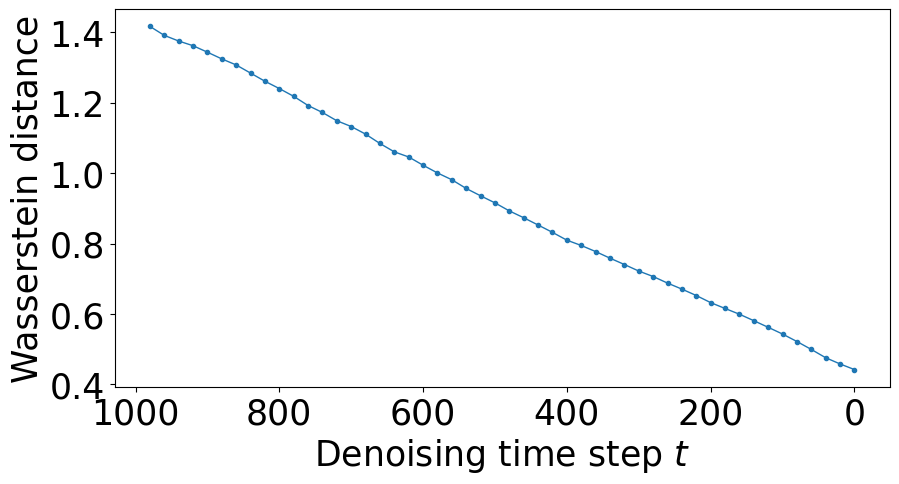

In [7]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.arange(0, 1000, 20)[::-1], wsds[::20], marker='o', markersize=3)   
plt.xlabel('Denoising time step $t$', fontsize=25)
plt.ylabel('Wasserstein distance', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.gca().invert_xaxis()
plt.show()


In [8]:
col2name = {'Si/Al': 'Si/Al',
            'Al/P': 'Al/P',
            'Si/Ge': 'Si/Ge',
            'Si/B': 'Si/B',
            'Na/T': 'Na/T',
            'K/T': 'K/T',
            'OH/T': 'OH/T',
            'F/T': 'F/T',
            'H2O/T': 'H$_2$O/T',
            'sda1/T': 'SDA/T',
            'cryst_temp': 'Cryst. temp',
            'cryst_time': 'Cryst. time',
            }

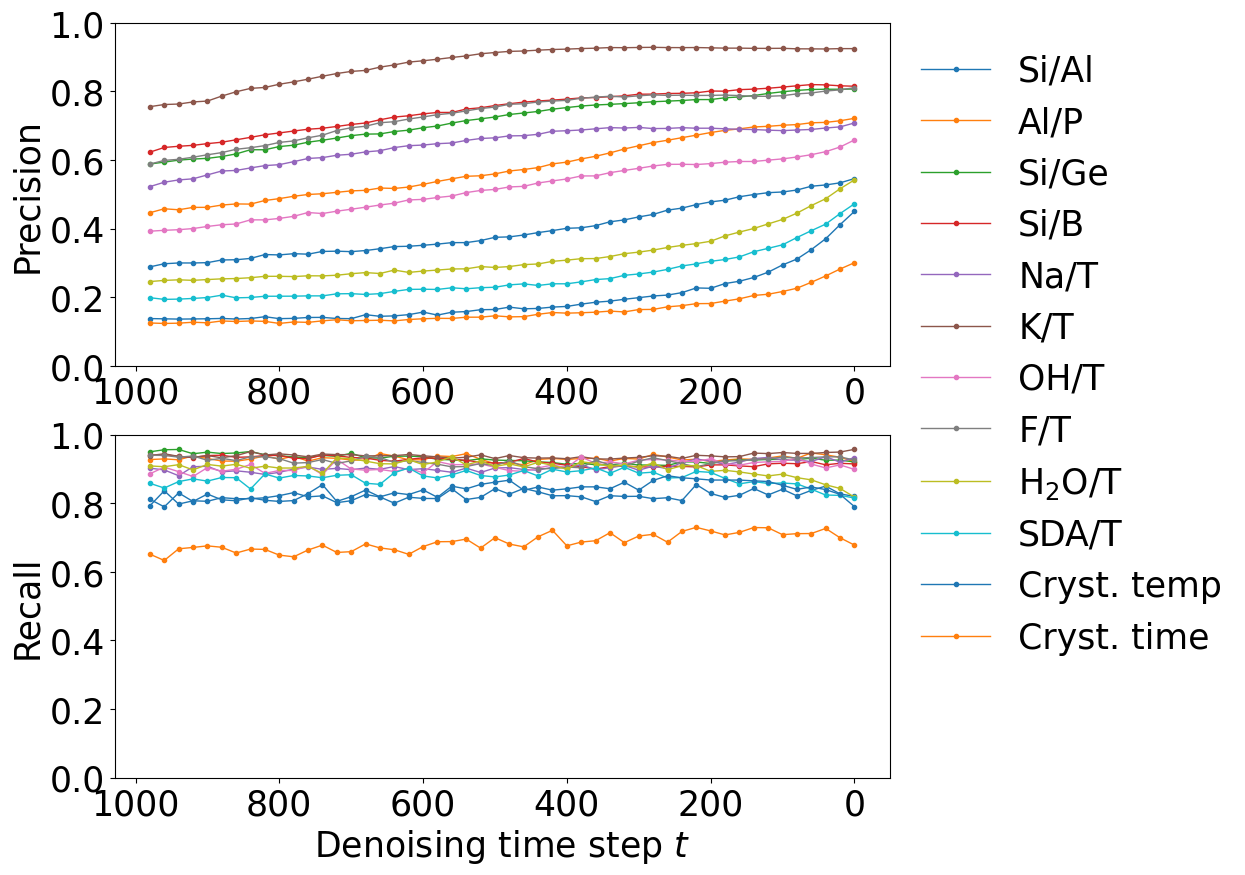

In [9]:
# Combined recall + precision
fig = plt.figure(figsize=(10, 10), dpi=100)
for i, metric in enumerate(['prec', 'rec']):
    fig.add_subplot(2, 1, i+1)
    if metric == 'prec':
        metric_df = precs
        split_str = '_prec'
    elif metric == 'rec':
        metric_df = recs
        split_str = '_rec'

    for col in metric_df.columns:
        plt.plot(np.arange(0, 1000, 20)[::-1], metric_df[col][::20], marker='o', markersize=3, label=col2name[col.split(split_str)[0]])   
    plt.ylim(0, 1)

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    if i==0:
        plt.ylabel(f'Precision', fontsize=25)
        plt.legend(fontsize=25)
    else:
        plt.ylabel(f'Recall', fontsize=25)
        plt.xlabel('Denoising time step $t$', fontsize=25)
    plt.gca().invert_xaxis()
plt.show()

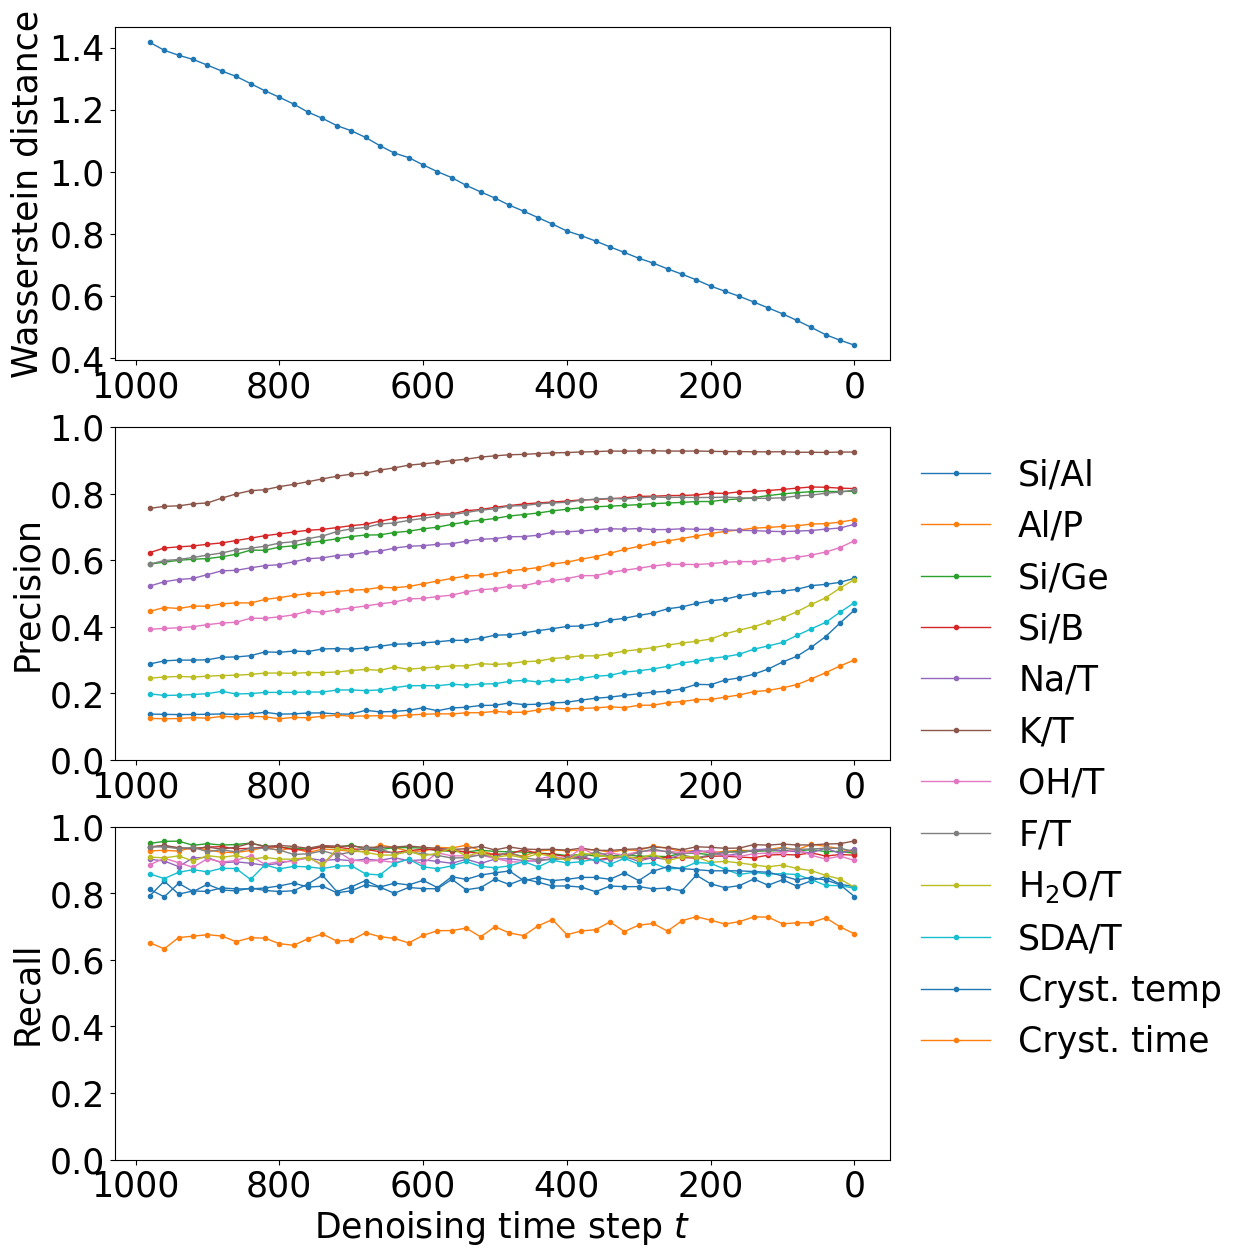

In [10]:
# Combined recall + precision
fig = plt.figure(figsize=(10, 15), dpi=100)

fig.add_subplot(3, 1, 1)
plt.plot(np.arange(0, 1000, 20)[::-1], wsds[::20], marker='o', markersize=3)   
plt.ylabel('Wasserstein distance', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.gca().invert_xaxis()

for i, metric in enumerate(['prec', 'rec']):
    fig.add_subplot(3, 1, i+2)
    if metric == 'prec':
        metric_df = precs
        split_str = '_prec'
    elif metric == 'rec':
        metric_df = recs
        split_str = '_rec'

    for col in metric_df.columns:
        plt.plot(np.arange(0, 1000, 20)[::-1], metric_df[col][::20], marker='o', markersize=3, label=col2name[col.split(split_str)[0]])   
    plt.ylim(0, 1)

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    if i==1:
        plt.ylabel(f'Recall', fontsize=25)
        plt.xlabel('Denoising time step $t$', fontsize=25)
    else:
        plt.ylabel(f'Precision', fontsize=25)
        plt.legend(fontsize=25)
    plt.gca().invert_xaxis()
plt.show()

# Metrics vs. hyperparameters

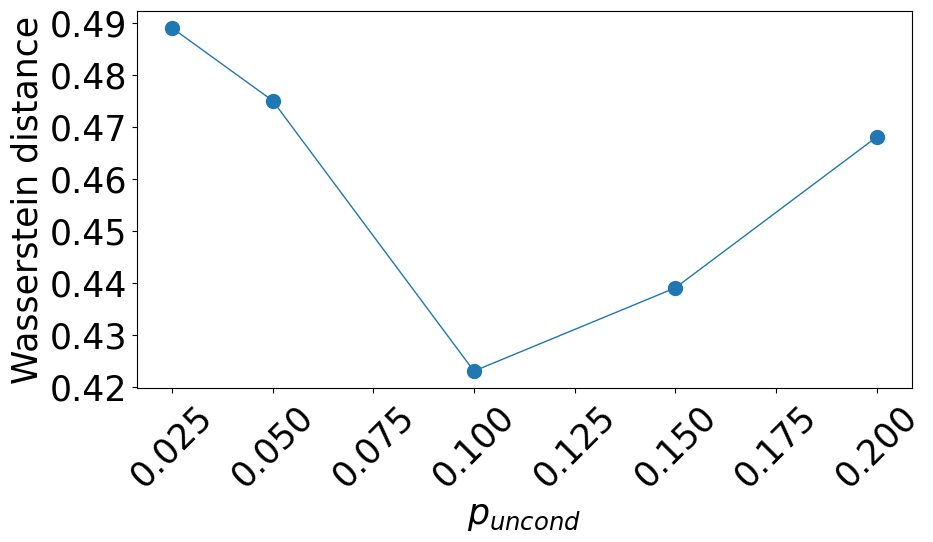

In [11]:
wsd_vs_cdp = pd.DataFrame({'cond_drop_prob': [0.025, 0.05, 0.10, 0.15, 0.2],
                            'wsd': [0.489, 0.475, 0.423, 0.439, 0.468]
                            }
                        )

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(wsd_vs_cdp['cond_drop_prob'], wsd_vs_cdp['wsd'], marker='o', markersize=10)   
plt.xlabel('$p_{uncond}$', fontsize=25)
plt.ylabel('Wasserstein distance', fontsize=25)
plt.xticks(fontsize=25, rotation=45)
plt.yticks(fontsize=25)
plt.show()


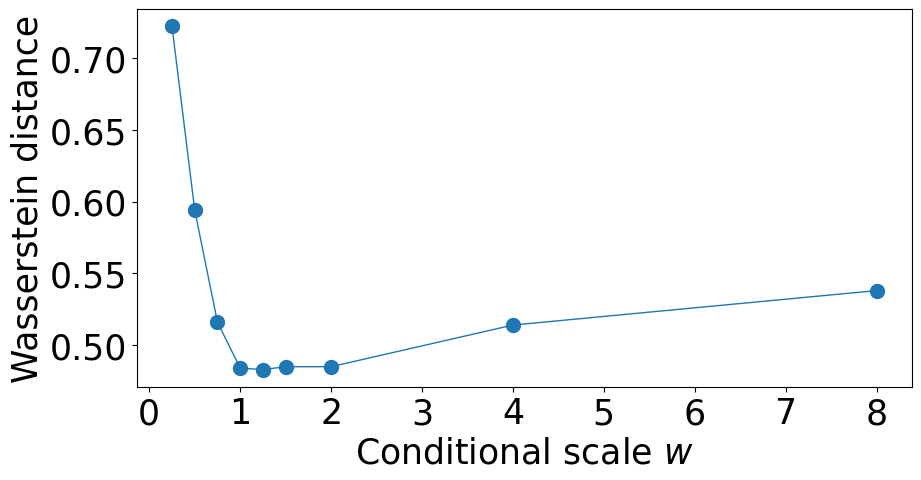

In [12]:
wsd_vs_cs = pd.DataFrame({'cond_scale': [0.25, 0.5, 0.75, 1., 1.25, 1.5, 2., 4, 8.],
                         'wsd': [0.722, 0.594, 0.516, 0.484, 0.483, 0.485, 0.485, 0.514, 0.538]
                            }
                        )

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(wsd_vs_cs['cond_scale'], wsd_vs_cs['wsd'], marker='o', markersize=10)   
plt.xlabel('Conditional scale $w$', fontsize=25)
plt.ylabel('Wasserstein distance', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()